# Natural Language Processing (NLP)

<img src="npl.png" alt="Bag of Words Model" width="800" height="400">


## Introduction

* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a **Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**

In [76]:
# File system manangement
import os
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from pathlib import Path
from pprint import pprint
from pandas import read_csv
from datetime import datetime


# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Visualisation libraries
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# sklearn machine learning algorithm
from sklearn.svm import SVC ,LinearSVC
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report,log_loss,f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB 
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Lasso, LogisticRegressionCV
from sklearn.model_selection import RepeatedKFold,ShuffleSplit,StratifiedKFold, KFold, RepeatedStratifiedKFold, StratifiedShuffleSplit, train_test_split, cross_val_score

# Grid Search
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report


# preprocessing
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer

## Reading and Exploring Dataset

In [77]:
def load_data(file_path):
    """
    Charge les données à partir du fichier CSV spécifié.
    
    Args:
    file_path (str): Chemin du fichier CSV.
    
    Returns:
    pandas.DataFrame: Les données chargées à partir du fichier CSV.
    """
    data = pd.read_csv(file_path, sep=',')
    data.reset_index(drop=True, inplace=True)
    data.sort_index(axis=0, inplace=True)
    return data

# Chemin vers le fichier CSV
path = '/Users/surelmanda/Downloads/AirGUARD/Tweeter_Sentiment_Analysis/development.csv'

# Charger les données à partir du fichier spécifié
data = load_data(path)

# Afficher la forme de l'ensemble de données
print("Les données en entrée ont {} lignes et {} colonnes".format(data.shape[0], data.shape[1]))

# Afficher quelque lignes de l'ensemble de données:
display(data.head())

Les données en entrée ont 224994 lignes et 6 colonnes


,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


## Exploration du dataset 

In [78]:
def resumer_info_dataframe(data):
    cols, dtype_col, specimens, nunique, null_share, null_count = [], [], [], [], [], []
    for column in data:
        cols.append(column)
        
        this_dtype = data[column].dtype
        dtype_col.append(this_dtype)
        
        specimen = data.loc[data[column].first_valid_index(), column]
        specimens.append(specimen)
        
        nunique.append(data[column].nunique())
        
        null_sum = data[column].isna().sum()
        null_to_len = null_sum / len(data[column])
        null_share.append(f'{null_to_len:.2%}')
        
        null_count.append(null_sum)
        
    df = pd.DataFrame(list(zip(dtype_col,specimens,nunique,null_share,null_count)),index=cols)    
    df.columns=['Type de données','Échantillon','Nombre d\'éléments uniques','% of de valeurs nulles','Nombre total de valeurs nulles']
 
    return df

In [79]:
resultat_summary = resumer_info_dataframe(data)
display(resultat_summary)

,Type de données,Échantillon,Nombre d'éléments uniques,% of de valeurs nulles,Nombre total de valeurs nulles
sentiment,int64,1,2,0.00%,0
ids,int64,1833972543,224716,0.00%,0
date,object,Mon May 18 01:08:27 PDT 2009,189779,0.00%,0
flag,object,NO_QUERY,1,0.00%,0
user,object,Killandra,10647,0.00%,0
text,object,"@MissBianca76 Yes, talking helps a lot.. going...",223106,0.00%,0


<span style="font-size:small">

# Observation :
1. Notre dataset ne contient aucune valeur NAN.
2. La colonne 'flag' contient une seule valeur unique, donc elle n'est vraiment pas utile.
3. Remplissez cette observation avec votre contenu.

</span>


In [80]:
# Renaming the columns :
data = data.rename(columns={'text': 'tweet'})

In [81]:
def evaluer_doublons_tweets(dataset):
    # Calculer le nombre total de tweets
    total_tweets = len(dataset)

    # Compter le nombre de tweets uniques
    tweets_uniques = dataset['tweet'].nunique()

    # Calculer le nombre de tweets dupliqués
    tweets_dupliques = total_tweets - tweets_uniques

    # Calculer les pourcentages
    pourcentage_uniques = (tweets_uniques / total_tweets) * 100
    pourcentage_dupliques = (tweets_dupliques / total_tweets) * 100

    # Créer un DataFrame pour la visualisation
    data = pd.DataFrame({
        'Type de tweet': ['Uniques', 'Dupliqués'],
        'Pourcentage': [pourcentage_uniques, pourcentage_dupliques]
    })

    # Visualisation avec Plotly Express
    fig = px.pie(data, values='Pourcentage', names='Type de tweet', title='Pourcentage de tweets uniques et dupliqués')
    #fig.show()
    fig.show(height=200, width=400)  # Vous pouvez ajuster les valeurs de height et width selon vos préférences

# Utilisation de la fonction avec votre dataset
evaluer_doublons_tweets(data)


In [82]:
def visualiser_sentiments(dataset):
    # Calculer les pourcentages de chaque valeur dans la colonne 'sentiment'
    pourcentage_sentiment = dataset['sentiment'].value_counts(normalize=True) * 100

    # Créer un DataFrame pour la visualisation
    data_pie = pd.DataFrame({
        'Sentiment': pourcentage_sentiment.index,
        'Pourcentage': pourcentage_sentiment.values
    })

    # Définir une palette de couleurs
    colors = px.colors.qualitative.Plotly

    # Créer les sous-tracés
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'bar'}]], subplot_titles=['Diagramme circulaire', 'Histogramme'])

    # Ajouter le diagramme circulaire
    fig.add_trace(go.Pie(labels=data_pie['Sentiment'], values=data_pie['Pourcentage'], name='', marker=dict(colors=colors)), row=1, col=1)

    # Ajouter l'histogramme
    fig.add_trace(go.Bar(x=data_pie['Sentiment'], y=data_pie['Pourcentage'], name='', marker=dict(color=colors)), row=1, col=2)

    # Mettre en forme la disposition des sous-tracés
    fig.update_layout(title='Pourcentage des sentiments (colonne cible)')

    # Afficher la figure
    fig.show()

# Utilisation de la fonction avec votre dataset
visualiser_sentiments(data)


In [83]:
import pandas as pd
import plotly.graph_objects as go

def visualiser_meilleurs_tweeters(dataset):
    # Regrouper les données par utilisateur et calculer le nombre total de tweets positifs et négatifs pour chaque utilisateur
    user_sentiments = dataset.groupby(['user', 'sentiment']).size().unstack(fill_value=0)

    # Calculer le nombre total de tweets positifs et négatifs pour chaque utilisateur
    user_sentiments['total'] = user_sentiments.sum(axis=1)

    # Trier les utilisateurs en fonction du nombre total de tweets positifs et négatifs
    user_sentiments = user_sentiments.sort_values(by='total', ascending=False).head(10)

    display(user_sentiments)

    # Créer un graphique à barres pour visualiser les 10 meilleurs tweeters
    fig = go.Figure(data=[
        go.Bar(name='Positif', x=user_sentiments.index, y=user_sentiments[1]),
        go.Bar(name='Négatif', x=user_sentiments.index, y=user_sentiments[0])
    ])

    # Mise en forme du graphique
    fig.update_layout(
        title='Les 10 meilleurs tweeters',
        xaxis_title='Utilisateur',
        yaxis_title='Nombre de Tweets',
        barmode='stack'
    )

    # Afficher le graphique
    fig.show()

# Utilisation de la fonction avec votre dataset
visualiser_meilleurs_tweeters(data)


sentiment,0,1,total
user,,,
lost_dog,412,0,412
webwoke,196,63,259
tweetpet,232,0,232
SallytheShizzle,142,69,211
VioletsCRUK,43,166,209
mcraddictal,157,50,207
tsarnick,30,156,186
what_bugs_u,0,184,184
Karen230683,90,88,178


In [84]:
def top_tweeters_summary(dataset, n=10):
    # Regrouper les données par utilisateur et calculer le nombre total de tweets positifs et négatifs pour chaque utilisateur
    user_sentiments = dataset.groupby(['user', 'sentiment']).size().unstack(fill_value=0)

    # Calculer le nombre total de tweets positifs et négatifs pour chaque utilisateur
    user_sentiments['total'] = user_sentiments.sum(axis=1)

    # Trier les utilisateurs en fonction du nombre total de tweets positifs et négatifs et sélectionner les n meilleurs tweeters
    top_tweeters = user_sentiments.sort_values(by='total', ascending=False).head(n)

    # Créer un DataFrame avec les colonnes demandées
    summary_df = pd.DataFrame({
        'nombre de tweet positif': top_tweeters[1],
        'nombre de tweet négatif': top_tweeters[0],
        'total tweet of user': top_tweeters['total']
    })

    return summary_df

# Utilisation de la fonction avec votre dataset
top_tweeters_summary_df = top_tweeters_summary(data)
display(top_tweeters_summary_df)


,nombre de tweet positif,nombre de tweet négatif,total tweet of user
user,,,
lost_dog,0,412,412
webwoke,63,196,259
tweetpet,0,232,232
SallytheShizzle,69,142,211
VioletsCRUK,166,43,209
mcraddictal,50,157,207
tsarnick,156,30,186
what_bugs_u,184,0,184
Karen230683,88,90,178


## **Préparation des données**

Notre prochaine étape consiste à préparer les tweets pour un travail ultérieur avec eux, à savoir, les nettoyer de toutes sortes de déchets qui pourraient affecter le résultat final.

**Étapes**
1. Supprimer les crochets (ils compliquent notre vie)
2. Se débarrasser de tous types de liens
3. Supprimer les balises
4. Effacer toutes les balises HTML (cela ne sera jamais superflu)
5. Nous ne prendrons que des mots
6. Mettre les phrases en minuscules
7. Tokenisation - le processus de division d'un document texte en mots séparés, appelés jetons.
8. Suppression des mots vides - mots fréquemment utilisés qui n'ajoutent aucune information supplémentaire au texte. Des mots comme "ce", "est", "un" n'ont aucune valeur et ne font que du bruit dans les données.
9. Nous pouvons choisir deux façons de procéder ensuite
    * **Stemmisation** est le processus de ramener un mot à sa racine/base. Il ramène diverses variations du mot (par exemple, "aider", "aide", "utile") à sa forme initiale (par exemple, "aider"), supprime tous les appendices des mots (préfixe, suffixe, terminaison) et ne laisse que la base du mot. La racine d'un mot peut être ou non un mot existant dans la langue. Par exemple, "mov" est la racine du mot "movie", "edit" est la racine du mot "emotion".

    * **Lemmatisation** est similaire à la stemmisation en ce qu'elle ramène un mot à sa forme initiale, mais avec une différence : dans ce cas, la racine du mot sera un mot existant dans la langue. Par exemple, le mot "caring" se terminera par "care", et non "car", comme dans la stemmisation. 

    ![Différence entre Stemming et Lemmatisation](https://d2mk45aasx86xg.cloudfront.net/difference_between_Stemming_and_lemmatization_8_11zon_452539721d.webp)


In [85]:
# Bibliothèques pour le traitement de texte et les utilitaires
import string
import pickle  # Importation du module pickle pour la sérialisation et la désérialisation d'objets Python
from string import punctuation  # Importation de la ponctuation depuis la bibliothèque string
from nltk.stem.porter import *  # Importation du stemmer de Porter depuis NLTK
import re  # pour les expressions régulières
import nltk  # pour la manipulation de texte
from nltk.corpus import stopwords  # Importation des mots vides depuis NLTK
from nltk.stem import WordNetLemmatizer  # Importation du lemmatizer WordNet depuis NLTK

In [86]:
# Définition des mots vides
stopword = set(stopwords.words('english'))

# Fonction de prétraitement du texte
def tweet_preprocessing(tweet):
    # Définition des modèles regex.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # Mettre le texte en minuscules
    tweet = tweet.lower()
    
    # Supprimer les URLs
    tweet = re.sub(urlPattern,'',tweet)
    
    # Supprimer les emojis et les noms d'utilisateur
    tweet = re.sub(userPattern,'', tweet)
    
    # Supprimer les caractères non alphabétiques et les séquences de lettres répétées
    tweet = re.sub(alphaPattern, " ", tweet)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # Tokenization et suppression des mots vides
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokenized_text = tokenizer.tokenize(tweet)
    # Supprimer les mots vides et combiner les mots restants avec une virgule comme séparateur
    text = [', '.join([word for word in tokenized_text if word not in stopword])]
    
    return text


In [87]:
# Sélection des fonctionnalités pertinentes pour le prétraitement et la copie des données
features = ['tweet', 'sentiment']
data_clean = data[features].copy()

# Application de la fonction de prétraitement à la colonne 'tweet' et création d'une nouvelle colonne 'tweet_cleaned'
data_clean['tweet_cleaned'] = data_clean['tweet'].apply(lambda x: tweet_preprocessing(x))

# Affichage des cinq premières lignes des données nettoyées
display(data_clean.head())

,tweet,sentiment,tweet_cleaned
0,"@MissBianca76 Yes, talking helps a lot.. going...",1,"[yes, talking, helps, lot, going, judgment, se..."
1,SUNSHINE. livingg itttt. imma lie on the grass...,1,"[sunshine, livingg, itt, imma, lie, grass, lis..."
2,@PleaseBeMine Something for your iphone,1,"[something, iphone]"
3,@GabrielSaporta couldn't get in to the after p...,0,"[get, party]"
4,@bradiewebbstack awww is andy being mean again...,0,"[aww, andy, mean, want, maccas]"


In [88]:
import re
import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer, word_tokenize, regexp_tokenize
nltk.download('punkt')

def add_news_features(data):
    """
    Ajoute plusieurs nouvelles fonctionnalités à un DataFrame de données textuelles.

    Arguments :
    data : DataFrame
        Le DataFrame contenant les données textuelles.

    Retourne :
    DataFrame
        Le DataFrame avec les nouvelles fonctionnalités ajoutées.
    """
    # Initialisation du Tweet Tokenizer
    tknzr = TweetTokenizer()

    # Fonction pour calculer la longueur moyenne des mots
    def mean_words_length(text):
        words = word_tokenize(text)
        word_lengths = [len(w) for w in words]
        return round(np.mean(word_lengths), 3)

    # Fonction pour compter les mots
    def words_count(text):
        return len(tknzr.tokenize(text))

    # Fonction pour compter les nombres
    def numbers_count(text):
        numbers_regex = r"(\d+\.?,?\s?\d+)"
        return len(regexp_tokenize(text, numbers_regex))

    # Fonction pour compter les hashtags
    def hashtags_count(text):
        hashtags_regex = r"#\w+"
        return len(regexp_tokenize(text, hashtags_regex))

    # Fonction pour compter les mentions
    def mentions_count(text):
        mentions_regex = r"@\w+"
        return len(regexp_tokenize(text, mentions_regex))

    # Fonction pour compter les URLs
    def url_count(text):
        return len([w for w in str(text).lower().split() if 'http' in w or 'https' in w])

    # Ajout des nouvelles fonctionnalités
    data['words_count'] = data['tweet'].apply(words_count)
    data['numbers_count'] = data['tweet'].apply(numbers_count)
    data['hashtags_count'] = data['tweet'].apply(hashtags_count)
    data['mentions_count'] = data['tweet'].apply(mentions_count)
    data['url_count'] = data['tweet'].apply(url_count)
    data['mean_words_length'] = data['tweet'].apply(mean_words_length)
    data['characters_count'] = data['tweet'].apply(len)

    return data


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/surelmanda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [89]:
# add_news_features(data_clean)
# display(data_clean.head(3))

In [90]:
import nltk
nltk.download('omw-1.4')

# Initialisation des stemmers et lemmatiseurs
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

def stemming(Texte):
    """
    Applique le stemming sur une liste de tokens.

    Arguments :
    Texte : list
        La liste de tokens, où chaque token est une chaîne de caractères contenant des mots séparés par des virgules.

    Retourne :
    list
        La liste de tokens après le stemming.
    """
    # Diviser chaque token en mots individuels en utilisant la virgule comme séparateur
    tokenized_text = [word.strip() for token in Texte for word in token.split(',')]
    
    # Appliquer le stemming à chaque mot
    text = [ps.stem(word) for word in tokenized_text]
    return text

def lemmatizing(Texte):
    """
    Applique la lemmatisation sur une liste de tokens.

    Arguments :
    Texte : list
        La liste de tokens, où chaque token est une chaîne de caractères contenant des mots séparés par des virgules.

    Retourne :
    list
        La liste de tokens après la lemmatisation.
    """
    # Diviser chaque token en mots individuels en utilisant la virgule comme séparateur
    tokenized_text = [word.strip() for token in Texte for word in token.split(',')]
    
    # Appliquer la lemmatisation à chaque mot
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/surelmanda/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [91]:
# Supposons que vous ayez une colonne 'body_text_nostop' dans votre DataFrame 'data' contenant des listes de tokens
data_clean['tweet_stemmed'] = data_clean['tweet_cleaned'].apply(lambda x: stemming(x))
data_clean['tweet_lemmatized'] = data_clean['tweet_cleaned'].apply(lambda x: lemmatizing(x))
display(data_clean.head())

,tweet,sentiment,tweet_cleaned,tweet_stemmed,tweet_lemmatized
0,"@MissBianca76 Yes, talking helps a lot.. going...",1,"[yes, talking, helps, lot, going, judgment, se...","[ye, talk, help, lot, go, judgment, sentenc, e...","[yes, talking, help, lot, going, judgment, sen..."
1,SUNSHINE. livingg itttt. imma lie on the grass...,1,"[sunshine, livingg, itt, imma, lie, grass, lis...","[sunshin, livingg, itt, imma, lie, grass, list...","[sunshine, livingg, itt, imma, lie, grass, lis..."
2,@PleaseBeMine Something for your iphone,1,"[something, iphone]","[someth, iphon]","[something, iphone]"
3,@GabrielSaporta couldn't get in to the after p...,0,"[get, party]","[get, parti]","[get, party]"
4,@bradiewebbstack awww is andy being mean again...,0,"[aww, andy, mean, want, maccas]","[aww, andi, mean, want, macca]","[aww, andy, mean, want, maccas]"


In [92]:
def check_zero_length(data, column):
    """
    Vérifie s'il y a des éléments de longueur nulle dans une colonne donnée du DataFrame.

    Arguments :
    data : DataFrame
        Le DataFrame contenant les données à vérifier.
    column : str
        Le nom de la colonne à vérifier.

    Retourne :
    int
        Le nombre de lignes avec une longueur nulle dans la colonne donnée.
    """
    # Crée un masque pour identifier les éléments de longueur nulle dans la colonne
    filters_zero_length = data[column].apply(lambda x: len(x) == 0)
    
    # Compte le nombre de lignes avec une longueur nulle
    rows_with_zero_length = filters_zero_length.sum()
    return rows_with_zero_length

tweets_null = check_zero_length(data_clean, 'tweet_cleaned')
print("Nombre de tweets avec une longueur de 0 :", tweets_null)

Nombre de tweets avec une longueur de 0 : 0


In [93]:
def create_train_and_evaluation_dataset(data_clean, test_size=0.2, random_state=None):
    """
    Creates a train and evaluation dataset by splitting the provided DataFrame.

    Parameters:
    - data_clean: DataFrame containing your data.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation, for reproducibility.

    Returns:
    Tuple of train and evaluation datasets (data_train, data_eval).
    """
    # Assuming 'sentiment' is the column you want to predict
    X = data_clean.drop('sentiment', axis=1)
    y = data_clean['sentiment']

    # Splitting the data into train and evaluation sets with stratify and shuffle
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=test_size, stratify=y, shuffle=True, random_state=random_state)

    # Create new DataFrame for train and evaluation datasets (if needed)
    data_train = pd.concat([X_train, y_train], axis=1)
    data_eval = pd.concat([X_eval, y_eval], axis=1)

    print(f"Dimensions of data_train : {data_train.shape}")
    print(f"Dimensions of data_eval : {data_eval.shape}")

    return data_train, data_eval

In [94]:
def split_train_test_data(X_original, y_original, test_size=0.12, random_state=None):
    """
    Divise les données en ensembles d'entraînement et de test avec stratification et mélange.

    Paramètres:
    - X_original : Features (caractéristiques) du jeu de données original.
    - y_original : Target (cible) du jeu de données original.
    - test_size : Proportion de l'ensemble de données à inclure dans l'ensemble de test.
    - random_state : Graine pour la génération de nombres aléatoires, pour la reproductibilité.

    Renvoie:
    Tuple contenant les ensembles d'entraînement et de test (X_train, X_test, y_train, y_test).
    """
    # Divise les données en ensembles d'entraînement et de test avec stratification et mélange
    X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=test_size, stratify=y_original, shuffle=True, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [95]:
def print_dataset_info(X_train, X_test, y_train, y_test):
    """
    Print information about the dimensions and classes of the input datasets.

    Parameters:
    - X_train, X_test: Feature matrices for training and testing.
    - y_train, y_test: Target vectors for training and testing.
    """
    # Print the dimensions of X_train, X_test, y_train, y_test

    print("")
    print(f"Dimensions of X_train: {X_train.shape}")
    print(f"Dimensions of X_test: {X_test.shape}")
    print(f"Dimensions of y_train: {y_train.shape}")
    print(f"Dimensions of y_test: {y_test.shape}")

    print("")

    # Print the number of unique classes in y_train and y_test
    num_classes_train = len(np.unique(y_train))
    num_classes_test = len(np.unique(y_test))
    print(f"Number of unique classes in y_train: {num_classes_train}")
    print(f"Number of unique classes in y_test: {num_classes_test}")

    print("")

    # Print the number of instances per class in y_train and y_test
    for class_label in np.unique(y_train):
        instances_train = np.sum(y_train == class_label)
        instances_test = np.sum(y_test == class_label)
        print(f"Class {class_label}: Train instances - {instances_train}, Test instances - {instances_test}")


In [96]:
def remove_punctuation(text):
    """
    Supprime la ponctuation d'une chaîne de texte.

    Paramètres :
    - text : str
        Chaîne de texte à nettoyer.

    Renvoie :
    str
        Chaîne de texte sans ponctuation.
    """
    # Utilisation de list comprehension pour supprimer la ponctuation
    text_no_punct = ' '.join([char for char in text if char not in punctuation])
    return text_no_punct

In [97]:
feature_to_transform = 'tweet_stemmed' #tweet_stemmed or tweet_lemmatized
data_clean['cleared_tweet'] = data_clean[feature_to_transform].apply(lambda x: remove_punctuation(x))


# Supprimer les colonnes spécifiées
colonnes_a_supprimer = ['tweet', 'tweet_cleaned', 'tweet_stemmed', 'tweet_lemmatized']
data_processing = data_clean.drop(colonnes_a_supprimer, axis=1) #, inplace=True)

# Afficher le DataFrame après suppression des colonnes
print(data_processing.head())  # Affiche les premières lignes du DataFrame pour vérifier que les colonnes ont été supprimées correctement


   sentiment                                      cleared_tweet
0          1  ye talk help lot go judgment sentenc end quot ...
1          1  sunshin livingg itt imma lie grass listen oasi...
2          1                                       someth iphon
3          0                                          get parti
4          0                           aww andi mean want macca


In [98]:
# Setting threshold values for evaluation and test datasets
threshold_eval = 0.10

# Creating train and test datasets based on the specified threshold and random state
train_df, eval_df = create_train_and_evaluation_dataset(data_processing, test_size=threshold_eval)

Dimensions of data_train : (202494, 2)
Dimensions of data_eval : (22500, 2)


## <a name="p7">Splitting the Dataset</a>
The Preprocessed Data is divided into 2 sets of data:
* **Training Data:** The dataset upon which the model would be trained on. Contains 70% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 30% data.

In [99]:
# Setting threshold values for evaluation and test datasets
threshold_test = 0.15

# Assuming 'sentiment' is the column you want to predict
X = train_df.drop('sentiment', axis=1)
y = train_df['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = split_train_test_data(X, y, test_size=threshold_test, random_state=424)

# Vérifier les dimensions des ensembles d'entraînement et de test
print_dataset_info(X_train, X_test, y_train, y_test)


Dimensions of X_train: (172119, 1)
Dimensions of X_test: (30375, 1)
Dimensions of y_train: (172119,)
Dimensions of y_test: (30375,)

Number of unique classes in y_train: 2
Number of unique classes in y_test: 2

Class 0: Train instances - 72550, Test instances - 12803
Class 1: Train instances - 99569, Test instances - 17572


### **Bag of Words (BoW) model**

Bag of Words (BOW) model - is the simplest form of text representation in numbers. Like the term itself, we can represent a sentence as a bag of words vector (a string of numbers).

> In NLP problems, each text sentence is called a document, and several such documents are called a corpus of texts.

<img src="nlp_2-2.jpg" alt="Bag of Words Model" width="1000" height="400">




In [100]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

X_train_review_bow = vect.fit_transform(X_train['cleared_tweet'])
X_test_review_bow = vect.transform(X_test['cleared_tweet'])

print('X_train_review_bow: ', X_train_review_bow.shape)
print('X_test_teview_bow: ', X_test_review_bow.shape)

X_train_review_bow:  (172119, 50178)
X_test_teview_bow:  (30375, 50178)


## **Term Frequency-Inverse Document Frequency (TF-IDF)**
<img src="TF-IDF.jpg" alt="Term Frequency-Inverse Document Frequency (TF-IDF)" width="1100" height="400">

***Term Frequency-Inverse Document Frequency (TF-IDF):*** is an algorithm commonly used in Natural Language Processing (NLP). It evaluates the importance of words within a document based on their frequency and relative importance in a corpus or set of documents.

Le principe du TF-IDF est de façon trompeusement simple. Il est le produit de deux métriques différentes, à savoir : 
1) La Fréquence du Terme (TF) et 
2) La Fréquence Inverse du Document (IDF).

***Term Frequency (TF):*** is the number of times a term (word) appears in a given document. The higher the frequency, the more important it is for that document. The TF of a word is usually calculated per document by dividing the number of times a word appears by the total number of words in a document.

***Inverse Document Frequency (IDF):*** evaluates the relative importance of the term across a collection of documents. The IDF of a word is calculated by taking the logarithm of the number of documents in the collection divided by the number of documents containing the given term. The more documents that contain a particular term, the less important it is to the collection.





In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_review_tfidf = vectorizer.fit_transform(X_train['cleared_tweet'])
X_test_review_tfidf = vectorizer.transform(X_test['cleared_tweet'])

print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_review_tfidf.shape)

X_train_review_tfidf shape:  (172119, 50178)
X_test_review_tfidf shape:  (30375, 50178)


In [102]:
data_transform = {"Bag of Words": (X_train_review_bow, X_test_review_bow), 'TF-IDF': (X_train_review_tfidf, X_test_review_tfidf)}

In [103]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from xgboost import XGBClassifier  # Si XGBoost est installé

def initialize_multi_label_classifiers():
    """
    Initialise un dictionnaire de classificateurs pour la classification multi-étiquettes.

    Returns:
    Dict: Dictionnaire de classificateurs initialisés, où les clés sont les noms des modèles et les valeurs sont les modèles eux-mêmes.
    """
    classifiers = {
        # 'Extra Trees': ExtraTreesClassifier(),      # Classifier 1: Extra Trees
        # 'Random Forest': RandomForestClassifier(),  # Classifier 2: Random Forest
        # 'K-Nearest Neighbors': KNeighborsClassifier(),  # Classifier 3: K-Nearest Neighbors
        'Logistic Regression': LogisticRegression(),  # Classifier 4: Régression logistique
        'Ridge Classifier': RidgeClassifier(),  # Classifier 5: Régression Ridge
        #'Linear SVM': LinearSVC(),  # Classifier 6: SVM linéaire
        #'SGD Classifier': SGDClassifier(),  # Classifier 7: Classificateur SGD
        'Multinomial Naive Bayes': MultinomialNB(),  # Classifier 8: Naive Bayes multinomial
        'Bernoulli Naive Bayes': BernoulliNB(alpha=2),  # Classifier 9: Naive Bayes Bernoulli avec alpha spécifié
        'Linear SVC': LinearSVC(),  # Classifier 10: SVM avec noyau linéaire

        # Ajoutez plus de classificateurs si nécessaire
    }
    return classifiers

In [104]:
def Metric_f1_score(y_test, y_pred):
    """
    Calcule le score F1 pour une classification.

    Paramètres :
    - y_test : array-like
        Valeurs cibles réelles.
    - y_pred : array-like
        Valeurs prédites.

    Renvoie :
    float : Score F1.
    """
    return f1_score(y_test, y_pred, average="macro")

import time

def Train_and_Evaluate_models(model, X_train, y_train, X_test, y_test):
    """
    Entraîne le modèle et évalue ses performances en utilisant diverses métriques.

    Paramètres :
    - model : Modèle d'apprentissage automatique à entraîner.
    - X_train : array-like
        Features du jeu de données d'entraînement.
    - y_train : array-like
        Valeurs cibles du jeu de données d'entraînement.
    - X_test : array-like
        Features du jeu de données de test.
    - y_test : array-like
        Valeurs cibles du jeu de données de test.

    Renvoie :
    float : Score F1_macro pour évaluer le modèle.
    """
    print(f"Entraînement du modèle avec {type(model).__name__}")

    start_time = time.time()  # Temps de début de l'entraînement

    # Entraînement du modèle
    model.fit(X_train, y_train)

    end_time = time.time()  # Temps de fin de l'entraînement
    training_time = end_time - start_time  # Temps écoulé pour l'entraînement

    print(f"Temps d'entraînement : {training_time:.2f} secondes")

    # Prédiction des valeurs pour le jeu de données de test
    y_pred = model.predict(X_test)

    # Affichage du rapport de classification pour le jeu de données de test
    print("Rapport de classification :\n", classification_report(y_test, y_pred))
    
    # Calcul du score F1_macro pour le jeu de données
    F1_macro = Metric_f1_score(y_test, y_pred)
    print(f"Score F1_macro (comportement du modèle avec de nouvelles données) : {F1_macro}")

    # Calcul et affichage de la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.3%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    heat_map = sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Valeurs prédites", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Valeurs réelles", fontdict={'size': 14}, labelpad=10)
    plt.title("Matrice de confusion", fontdict={'size': 18}, pad=20)
    plt.show()
    print(' ') 
    return F1_macro



====> Extraction des données transformées avec Bag of Words:
Données d'entraînement : (172119, 50178)
Données de test : (30375, 50178)
Train model: Logistic Regression & Bag of Words
Entraînement du modèle avec LogisticRegression
Temps d'entraînement : 5.48 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.75      0.67      0.71     12803
           1       0.78      0.84      0.81     17572

    accuracy                           0.77     30375
   macro avg       0.77      0.76      0.76     30375
weighted avg       0.77      0.77      0.77     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7586764981731962


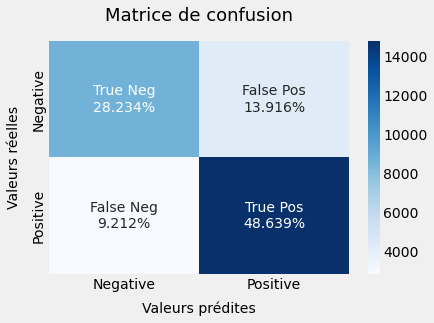

 
Train model: Ridge Classifier & Bag of Words
Entraînement du modèle avec RidgeClassifier
Temps d'entraînement : 5.59 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.64      0.69     12803
           1       0.76      0.84      0.80     17572

    accuracy                           0.76     30375
   macro avg       0.75      0.74      0.74     30375
weighted avg       0.75      0.76      0.75     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7437564501398712


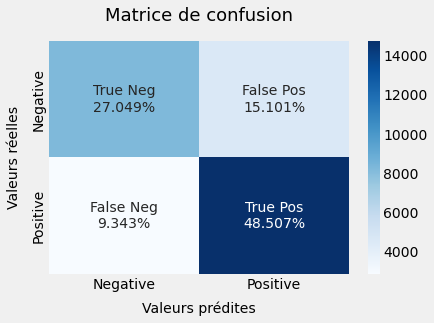

 
Train model: Multinomial Naive Bayes & Bag of Words
Entraînement du modèle avec MultinomialNB
Temps d'entraînement : 0.04 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.73      0.69      0.71     12803
           1       0.78      0.81      0.80     17572

    accuracy                           0.76     30375
   macro avg       0.75      0.75      0.75     30375
weighted avg       0.76      0.76      0.76     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7522712311123569


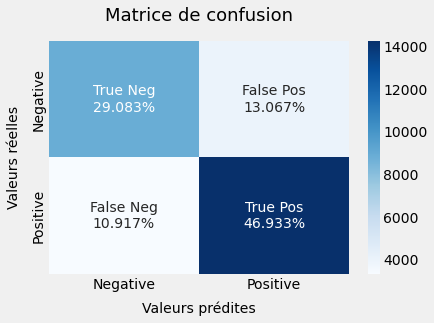

 
Train model: Bernoulli Naive Bayes & Bag of Words
Entraînement du modèle avec BernoulliNB
Temps d'entraînement : 0.05 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.75      0.62      0.68     12803
           1       0.76      0.85      0.80     17572

    accuracy                           0.75     30375
   macro avg       0.75      0.74      0.74     30375
weighted avg       0.75      0.75      0.75     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.740170350500144


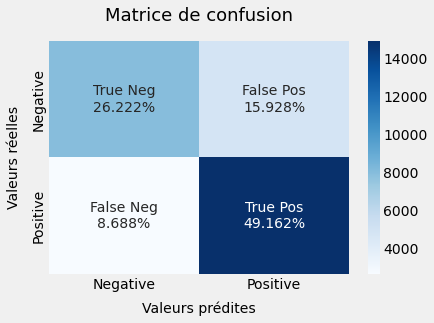

 
Train model: Linear SVC & Bag of Words
Entraînement du modèle avec LinearSVC
Temps d'entraînement : 27.05 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.73      0.66      0.70     12803
           1       0.77      0.83      0.80     17572

    accuracy                           0.76     30375
   macro avg       0.75      0.74      0.75     30375
weighted avg       0.76      0.76      0.75     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7466649157218896


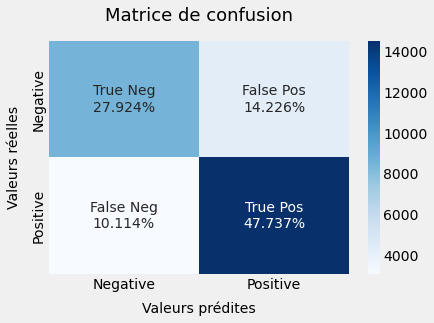

 
------------------------------------------
====> Extraction des données transformées avec TF-IDF:
Données d'entraînement : (172119, 50178)
Données de test : (30375, 50178)
Train model: Logistic Regression & TF-IDF
Entraînement du modèle avec LogisticRegression
Temps d'entraînement : 5.41 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.75      0.68      0.71     12803
           1       0.78      0.84      0.81     17572

    accuracy                           0.77     30375
   macro avg       0.77      0.76      0.76     30375
weighted avg       0.77      0.77      0.77     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7604562474147034


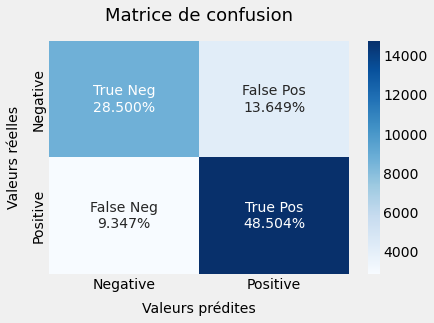

 
Train model: Ridge Classifier & TF-IDF
Entraînement du modèle avec RidgeClassifier
Temps d'entraînement : 1.93 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.67      0.70     12803
           1       0.78      0.83      0.80     17572

    accuracy                           0.76     30375
   macro avg       0.76      0.75      0.75     30375
weighted avg       0.76      0.76      0.76     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7531742625009483


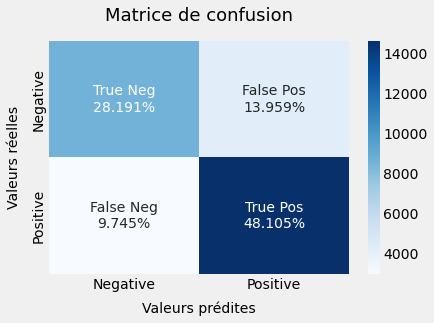

 
Train model: Multinomial Naive Bayes & TF-IDF
Entraînement du modèle avec MultinomialNB
Temps d'entraînement : 0.03 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.77      0.58      0.66     12803
           1       0.74      0.87      0.80     17572

    accuracy                           0.75     30375
   macro avg       0.76      0.73      0.73     30375
weighted avg       0.75      0.75      0.74     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7336998179002491


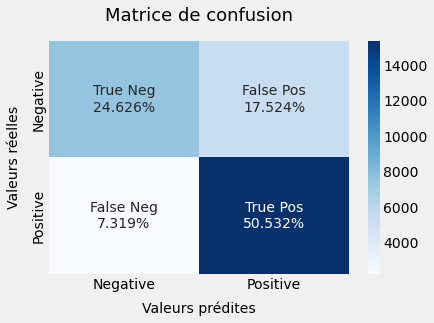

 
Train model: Bernoulli Naive Bayes & TF-IDF
Entraînement du modèle avec BernoulliNB
Temps d'entraînement : 0.05 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.75      0.62      0.68     12803
           1       0.76      0.85      0.80     17572

    accuracy                           0.75     30375
   macro avg       0.75      0.74      0.74     30375
weighted avg       0.75      0.75      0.75     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.740170350500144


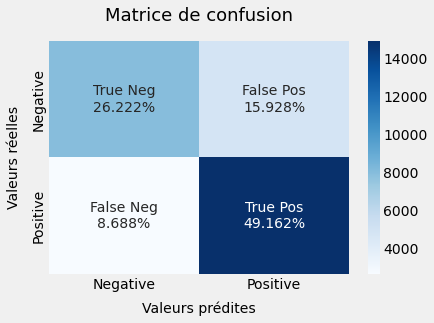

 
Train model: Linear SVC & TF-IDF
Entraînement du modèle avec LinearSVC
Temps d'entraînement : 1.94 secondes
Rapport de classification :
               precision    recall  f1-score   support

           0       0.74      0.68      0.71     12803
           1       0.78      0.82      0.80     17572

    accuracy                           0.76     30375
   macro avg       0.76      0.75      0.75     30375
weighted avg       0.76      0.76      0.76     30375

Score F1_macro (comportement du modèle avec de nouvelles données) : 0.7531842674453499


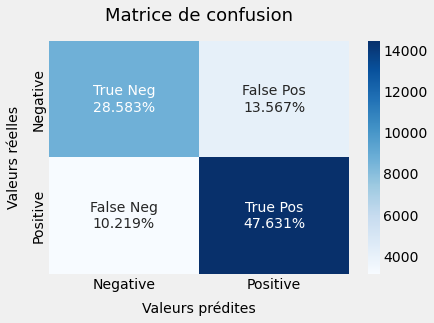

 
------------------------------------------


In [105]:
# Initialisation des classificateurs
classifiers = initialize_multi_label_classifiers()

# Initialisation du dictionnaire pour stocker les résultats
results = {}

Bag_of_Words_f1_scores= []
TF_IDF_f1_scores = []
models = [name_model for name_model in classifiers.keys()]

# Boucle sur les données transformées
for name_data, data_transf in data_transform.items():
    print(f"====> Extraction des données transformées avec {name_data}:")
    
    # Récupération des données d'entraînement et de test
    data_train, data_test = data_transf

    # Affichage du contenu des données d'entraînement
    print("Données d'entraînement :", data_train.shape)
    
    # Affichage du contenu des données de test
    print("Données de test :", data_test.shape)
    
    # Boucle sur les classificateurs
    for name_model, model in classifiers.items():
        # Nom unique pour le modèle et les données
        name = f"{name_model} & {name_data}"

        # Affichage du nom unique
        print("Train model:", name)
        
        # Évaluation du modèle et stockage du résultat
        #results[name] = Train_and_Evaluate_models(model, data_train, data_test)
        f1 = Train_and_Evaluate_models(model,data_train,y_train, data_test,y_test)  
        
        if name_data == "Bag of Words":
            Bag_of_Words_f1_scores.append(f1)
        else:
            TF_IDF_f1_scores.append(f1)
    print("------------------------------------------")


In [106]:
# Conversion du dictionnaire en DataFrame
transf_data = pd.DataFrame({
    "Model": models,
    "Bag_of_Words_F1_Score": Bag_of_Words_f1_scores,
    "TF_IDF_F1_Score": TF_IDF_f1_scores
})

display(transf_data)

,Model,Bag_of_Words_F1_Score,TF_IDF_F1_Score
0,Logistic Regression,0.758676,0.760456
1,Ridge Classifier,0.743756,0.753174
2,Multinomial Naive Bayes,0.752271,0.733700
3,Bernoulli Naive Bayes,0.740170,0.740170
4,Linear SVC,0.746665,0.753184


In [107]:
import plotly.express as px

# Conversion du DataFrame en format long
transf_data_long = pd.melt(transf_data, id_vars=["Model"], var_name="Feature", value_name="F1_Score")

# Création du graphique
fig = px.bar(transf_data_long, x="Model", y="F1_Score", color="Feature", barmode="group",
             title="Scores F1 pour Bag of Words et TF-IDF par modèle",
             labels={"Model": "Modèle", "F1_Score": "Score F1", "Feature": "Type de représentation"})

# Affichage du graphique
fig.show()


In [108]:
# Calcul de la moyenne des scores F1 pour Bag of Words et TF-IDF
avg_scores = transf_data.melt(id_vars=["Model"], value_vars=["Bag_of_Words_F1_Score", "TF_IDF_F1_Score"], var_name="Representation", value_name="F1_Score")
avg_scores = avg_scores.groupby("Representation")["F1_Score"].mean().reset_index()

# Trouver la valeur maximale
max_score = avg_scores["F1_Score"].max()

# Ajouter une colonne pour indiquer si la valeur est maximale
avg_scores["Max_Score"] = avg_scores["F1_Score"] == max_score

# Création du graphique avec mise en forme
fig = px.bar(avg_scores, x="Representation", y="F1_Score", 
             title="Moyenne des scores F1 pour Bag of Words et TF-IDF",
             labels={"Representation": "Type de représentation", "F1_Score": "Score F1 moyen"},
             color="Max_Score",
             color_discrete_map={True: "red", False: "blue"})

# Redimensionnement du graphique
fig.update_layout(width=800, height=500)

# Affichage du graphique
fig.show()

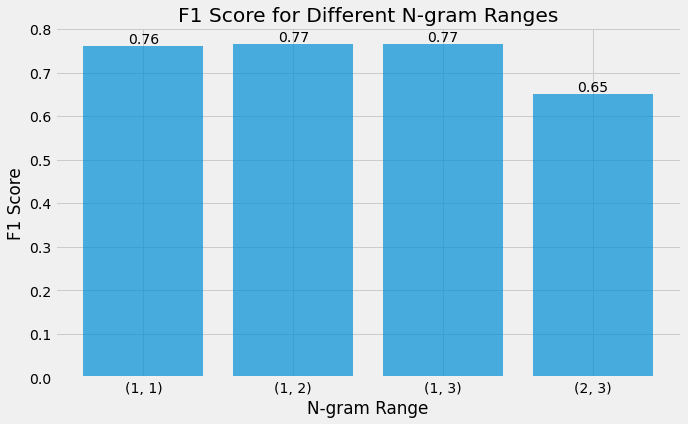

In [137]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# List of n-gram ranges
list_of_ngram_range = [(1, 1), (1, 2), (1, 3), (2, 3)]

# Dictionary to store F1 scores for each n-gram
f1_scores = {}

for ngram in list_of_ngram_range:
    # Initialize TfidfVectorizer with specified parameters
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram,max_df=1.0, min_df=1, max_features=None, norm='l2')

    # Use TfidfVectorizer to transform your text data
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleared_tweet'])
    
    # Initialize Logistic Regression model
    model = LogisticRegression()

    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Predict on the validation set
    X_test_tfidf = tfidf_vectorizer.transform(X_test['cleared_tweet'])
    y_pred = model.predict(X_test_tfidf)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Save the F1 score for each n-gram
    f1_scores[ngram] = f1

# Visualize F1 scores
ngram_labels = [str(ngram) for ngram in list_of_ngram_range]
f1_values = [f1_scores[ngram] for ngram in list_of_ngram_range]

plt.figure(figsize=(10, 6))
bars = plt.bar(np.arange(len(list_of_ngram_range)), f1_values, align='center', alpha=0.7)
plt.xticks(np.arange(len(list_of_ngram_range)), ngram_labels)
plt.xlabel('N-gram Range')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different N-gram Ranges')

# Add annotation with real values on each bar
for bar, value in zip(bars, f1_values):
    plt.text(bar.get_x() + bar.get_width() / 2, value, round(value, 2), ha='center', va='bottom')

plt.show()

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

# Définir le nombre de plis (cv=5 dans votre cas)
n_splits = 5

# Créer l'objet StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Créer l'objet ShuffleSplit
shuffle_split = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

# Créer la fonction de scoring F1-macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Créer un pipeline avec TF-IDF et régression logistique
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression()) # n_jobs=-1
])

# Définir la grille de paramètres
param_grid = {
    'tfidf__ngram_range': [(1, 2), (1, 3)],  # Essayez différents n-grammes
    'tfidf__max_df': [0.1, 0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2],
    #'tfidf__binary': [True, False],
    #'tfidf__norm': ['l1', 'l2'],
    #'tfidf__use_idf': [True, False],
    #'tfidf__smooth_idf': [True, False],
    #'tfidf__sublinear_tf': [True, False],
    'clf__C': [0.001, 0.01, 1],
    'clf__penalty': ['l1', 'l2']
}

# Utiliser GridSearchCV avec validation croisée stratifiée
grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, scoring=f1_macro_scorer, n_jobs=-1)

# Exécuter la recherche sur la grille
grid_search.fit(X_train['cleared_tweet'], y_train)

/Users/surelmanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/surelmanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.001, 0.01, 1],
                         'clf__penalty': ['l1', 'l2'],
                         'tfidf__max_df': [0.1, 0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 2), (1, 3)]},
             scoring=make_scorer(f1_score, average=macro))

GridSearch CV best score: 0.7670
Meilleurs paramètres trouvés: {'clf__C': 1, 'clf__penalty': 'l2', 'tfidf__max_df': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
GridSearch CV test score: 0.7661
Parameters that give the best results:  {'clf__C': 1, 'clf__penalty': 'l2', 'tfidf__max_df': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Estimator that was chosen by the search:  Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.1, min_df=2, ngram_range=(1, 3))),
                ('clf', LogisticRegression(C=1))])
              precision    recall  f1-score   support

           0       0.76      0.68      0.72     12803
           1       0.79      0.84      0.81     17572

    accuracy                           0.78     30375
   macro avg       0.77      0.76      0.77     30375
weighted avg       0.77      0.78      0.77     30375

accuracy_score(When the model sees new data): 77.50% accuracy score


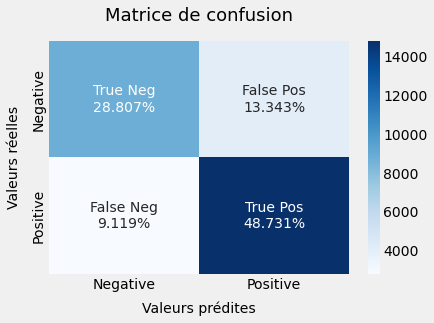

In [151]:
# Best score achieved during the GridSearchCV
print(f'GridSearch CV best score: {grid_search.best_score_:.4f}')

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres trouvés:", best_params)

# Test score of the best model on the test set
test_score = grid_search.score(X_test['cleared_tweet'], y_test)
print(f'GridSearch CV test score: {test_score:.4f}')

# Parameters that resulted in the best score
print('Parameters that give the best results: ', grid_search.best_params_)

# Estimator that was chosen as the best by the grid search
print('Estimator that was chosen by the search: ', grid_search.best_estimator_)

# Predict values for the test dataset using the best model
y_pred = grid_search.best_estimator_.predict(X_test['cleared_tweet'])

# Print classification report and accuracy for the test dataset
print(classification_report(y_test, y_pred))
accuracy = round(accuracy_score(y_test, y_pred), 3)
print(f"accuracy_score(When the model sees new data): {accuracy * 100:.2f}% accuracy score")

# Calcul et affichage de la matrice de confusion
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Negative', 'Positive']
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.3%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

heat_map = sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)
plt.xlabel("Valeurs prédites", fontdict={'size': 14}, labelpad=10)
plt.ylabel("Valeurs réelles", fontdict={'size': 14}, labelpad=10)
plt.title("Matrice de confusion", fontdict={'size': 18}, pad=20)
plt.show()

In [149]:
C = np.logspace(-2, 1, 10).tolist()
C

[0.01,
 0.021544346900318832,
 0.046415888336127774,
 0.1,
 0.21544346900318834,
 0.46415888336127775,
 1.0,
 2.154434690031882,
 4.6415888336127775,
 10.0]